In [ ]:
import re

# Read the input TSV file
with open("lt400.txt", "r") as infile, open("lt400.tsv", "w") as outfile:
    for line in infile:
        # Remove unwanted characters using regular expressions
        line = re.sub(r'[()]', '', line)
        #line = re.sub(r'"', '', line)
        line = re.sub(r'"', '',line)
        # Remove unwanted characters using the translate() function
        #line = line.translate({ord('('): None, ord(')'): None, ord('"'): None})

        # Replace commas with tabs
        #line = line.replace(',', '\t')

        # Write the modified line to the output TSV file
        outfile.write(line)


In [ ]:


import os
import glob
import librosa
import numpy as np
import soundfile as sf

def add_white_noise(input_filename, output_filename, desired_snr):
    # Read the input audio file
    signal, sr = librosa.load(input_filename, sr=None)

    # Remove silence from the start and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal)

    # Generate white noise
    noise = np.random.normal(0, 1, trimmed_signal.shape)

    # Calculate the signal and noise power
    signal_power = np.sum(trimmed_signal ** 2) / trimmed_signal.size
    noise_power = np.sum(noise ** 2) / noise.size

    # Calculate the scaling factor for the desired SNR level
    scaling_factor = np.sqrt((signal_power / noise_power) * 10 ** (-desired_snr / 10))

    # Scale the noise
    noise_scaled = noise * scaling_factor

    # Add the scaled white noise to the trimmed signal
    noisy_signal = trimmed_signal + noise_scaled

    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)

input_folder = 'lt400'
output_folder = 'output_folder'
snr_values = [-10, 0, 10, 20, 30, 40]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_snr in snr_values:
    output_folder = os.path.join(output_folder, f'SNR{desired_snr}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        add_white_noise(file, output_filename, desired_snr)






In [ ]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv("lt400.tsv", sep="\t", index=False)

input_folder = "lt400/"
transcribe_files_to_tsv(input_folder)


In [ ]:
import csv
from pathlib import Path

ORIGINAL_FOLDER = "lt400"
augmented_folder = "SNR30"

# Define the folder path where the TSV file is located
folder_path = Path(ORIGINAL_FOLDER)

# Construct the TSV file path
tsv_file_path = folder_path / "lt400.tsv"

# Read the TSV file and store its contents in a dictionary
tsv_data = {}

with open(tsv_file_path, "r") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    next(tsv_file)  # Skip header row
    for line in tsv_file:
        filename, transcription = line
        tsv_data[filename] = {
            "transcription": transcription
        }

print(tsv_data)   




In [ ]:
def replace_first_space_with_tab(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            modified_line = line.replace(' ', '\t', 1)
            outfile.write(modified_line)


input_file = 'lt400.tsv'
output_file = 'output.tsv'
replace_first_space_with_tab(input_file, output_file)



In [ ]:
def remove_first_space(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            modified_line = line[1:]
            if modified_line:
                outfile.write(modified_line + '\n')


input_file = 'lt400.tsv'
output_file = 'output.tsv'
remove_first_space(input_file, output_file)


In [ ]:
def add_wav(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            filename, ext = os.path.splitext(line.strip())
            new_filename = filename + '.wav' + ext
            outfile.write(new_filename + '\n')


add_wav('lt400.tsv', 'output.tsv')



In [ ]:
import csv
from pathlib import Path
from jiwer import wer

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer(original_data, augmented_data):
    # Calculate WER for each file
    output = {}
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            wer_score = wer(original_transcription, augmented_transcription)
            print(f"WER for file {filename}: {wer_score:.2f}")
            output[filename] = wer_score
        else:
            print(f"No augmented transcription found for file {filename}")
    return (output)

# Example usage
tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)

tsvaugmented_file_path = Path("SNR40/SNR40.tsv")
tsvaugmented_data = read_tsv_file(tsvaugmented_file_path)

print(tsv_data)
print(tsvaugmented_data)
wer = calculate_wer(tsv_data, tsvaugmented_data)
print(wer)


In [ ]:
import csv
from pathlib import Path
from jiwer import wer

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer(original_data, augmented_data):
    # Calculate WER for each file
    output = {}
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            wer_score = wer(original_transcription, augmented_transcription)
            #print(f"WER for file {filename}: {wer_score:.2f}")
            output[filename] = wer_score
        else:
            print(f"No augmented transcription found for file {filename}")

    return(output)

# Example usage
tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)

tsvaugmented_file_path = Path("SNR30/SNR30.tsv")
tsvaugmented_data = read_tsv_file(tsvaugmented_file_path)

data = calculate_wer(tsv_data, tsvaugmented_data)
print(data)


In [ ]:
import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return -1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, SNR):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = -1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), SNR])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "SNR"])
        writer.writerows(output)


ORIGINAL_FOLDER = "lt400"
augmented_folder = "SNR40"

tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


SNR40_path = Path("SNR40/SNR40.tsv")
SNR40 = read_tsv_file(SNR40_path)


output_SNR40 = Path("OUTPUT40DB.tsv")


calculate_wer_pesq(tsv_data, SNR40, output_SNR40,40)




In [ ]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Group the data by SNR
    grouped_data = {}
    for snr, wer, pesq in zip(data["SNR"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each SNR
    avg_data = {}
    for snr, snr_data in grouped_data.items():
        avg_wer = np.mean(snr_data["WER"])
        avg_pesq = np.mean(snr_data["PESQ"])
        avg_data[snr] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT0DB.tsv"),
    Path("OUTPUT10DB.tsv"),
    Path("OUTPUT20DB.tsv"),
    Path("OUTPUT30DB.tsv"),
    Path("OUTPUT40DB.tsv")
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each SNR
    for snr, snr_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"SNR {snr}")
        plt.subplot(2, 1, 1)
        plt.plot(snr_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(snr_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all SNRs
snrs = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each SNR
    # (same as before)

# Plot the average WER data for all SNRs
snrs = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all SNRs
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(snrs, avg_pesqs, 'o-')
plt.xlabel("SNR")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(snrs, avg_wers, 'o-')
plt.xlabel("SNR")
plt.ylabel("Average WER")
plt.show()


output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


In [ ]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Group the data by SNR
    grouped_data = {}
    for snr, wer, pesq in zip(data["SNR"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Create subplots for each SNR level
    num_snrs = len(grouped_data)
    if num_snrs == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_snrs, 2, figsize=(10, 10), sharey=True)

    for i, (snr, snr_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(snr_data["WER"], range=(-1, 1), bins=20)
        axs[i][1].hist(snr_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_snrs == 1:
            axs[i][0].set_title("Histogram of WER and PESQ")
        else:
            axs[i][0].set_title(f"Histogram of WER (SNR {snr})")
            axs[i][1].set_title(f"Histogram of PESQ (SNR {snr})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()



output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)



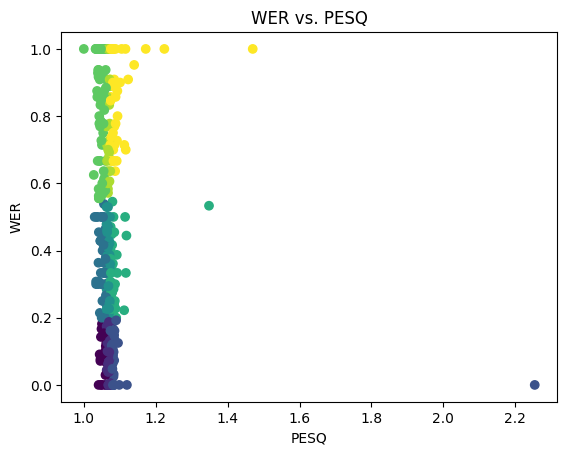

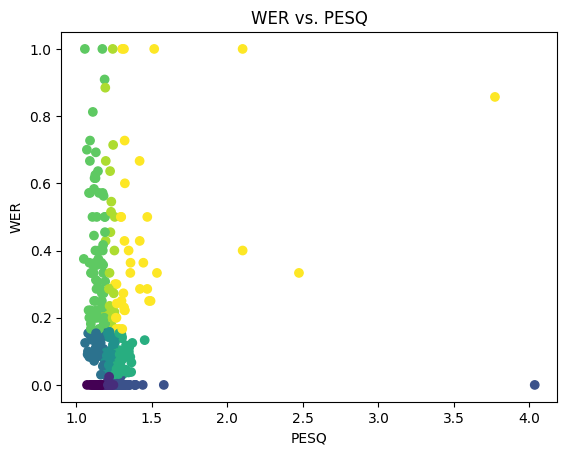

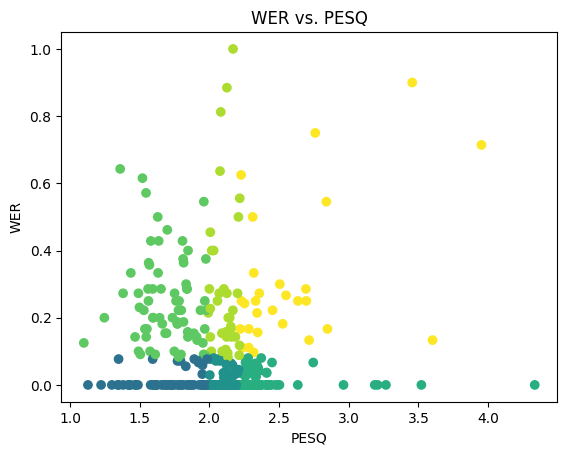

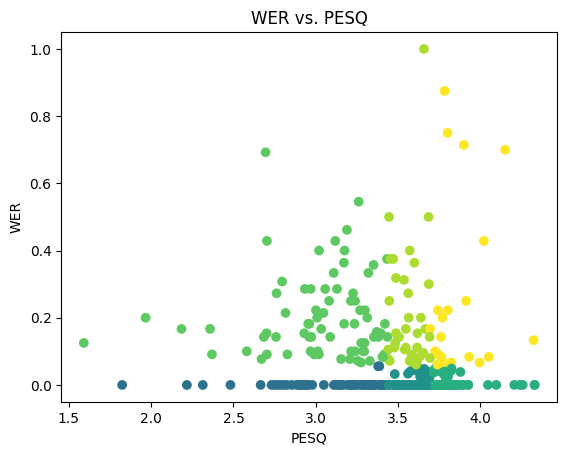

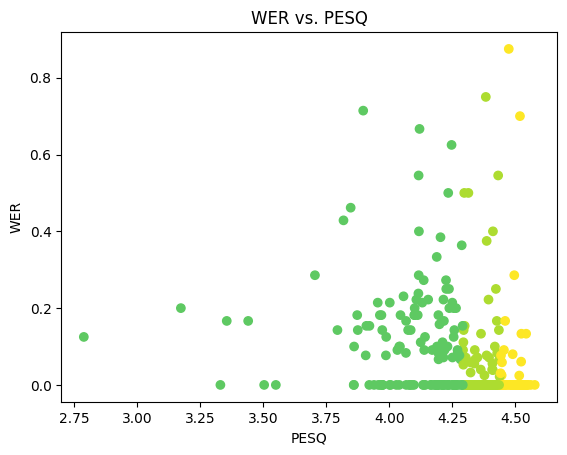

In [19]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)
    data["PESQ"] = np.clip(data["PESQ"], 1, 5)

    # Calculate combined scores and their percentiles
    combined_scores = np.array(data["WER"]) + np.array(data["PESQ"])
    combined_percentiles = np.percentile(combined_scores, [33, 66])  # [numpy.org](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)

    wer_percentiles = np.percentile(data["WER"], [33.33, 66.67])
    pesq_percentiles = np.percentile(data["PESQ"], [33.33, 66.67])

    wer_colors = np.digitize(data["WER"], wer_percentiles)
    pesq_colors = np.digitize(data["PESQ"], pesq_percentiles)
    color_matrix = np.array([wer_colors, pesq_colors]).T

    unique_colors = wer_colors * 3 + pesq_colors

    # Assign colors based on the percentiles of the combined scores
    colors = np.digitize(combined_scores, combined_percentiles)

    # Create scatter plot
    plt.scatter(data["PESQ"], data["WER"], c=unique_colors, cmap='viridis', vmin=0, vmax=8)
    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.title("WER vs. PESQ")
    #plt.colorbar(ticks=range(9))
    plt.show()


output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


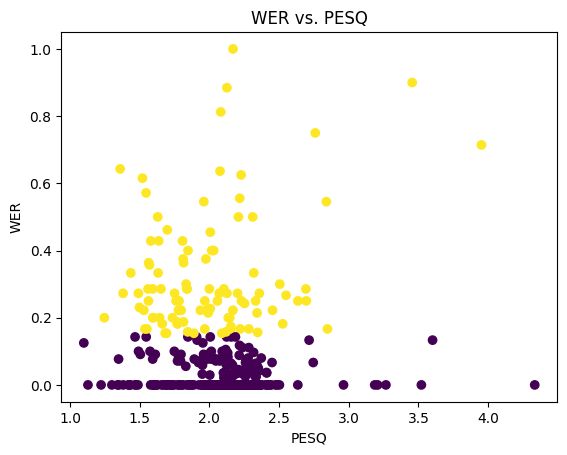

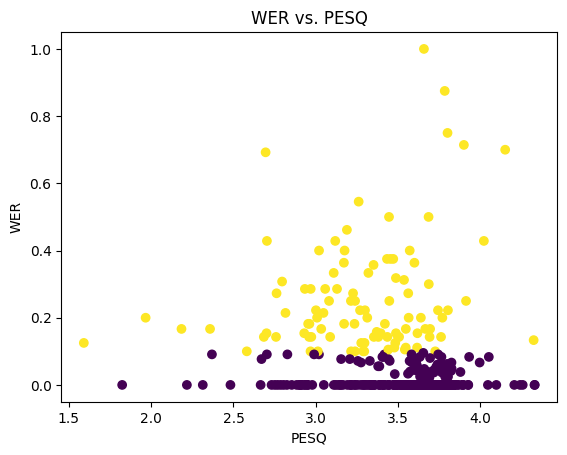

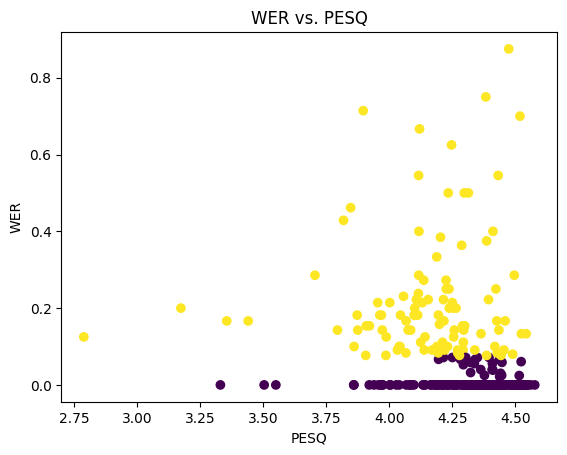

In [20]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)
    data["PESQ"] = np.clip(data["PESQ"], 1, 5)

    # Calculate combined scores and their percentiles
    combined_scores = np.array(data["WER"]) #+ np.array(data["PESQ"])
    
    combined_percentiles = np.percentile(combined_scores, [25, 75])  # [numpy.org](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)

    # Assign colors based on the percentiles of the combined scores
    colors = np.digitize(data["WER"], combined_percentiles)

        # Assign colors based on the percentiles of the combined scores
    # colors = np.zeros(len(combined_scores))
    # colors[combined_scores <= combined_percentiles[0]] = 0
    # colors[(combined_scores > combined_percentiles[0]) & (combined_scores <= combined_percentiles[1])] = 1
    # colors[combined_scores > combined_percentiles[1]] = 2

    # Create scatter plot
    plt.scatter(data["PESQ"], data["WER"], c=colors)
    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.title("WER vs. PESQ")
    #plt.colorbar(ticks=[0, 1, 2])
    plt.show()

#output_file_path = Path("OUTPUT0DB.tsv")
#output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

#plot_wer_pesq(output_file_path)
#plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


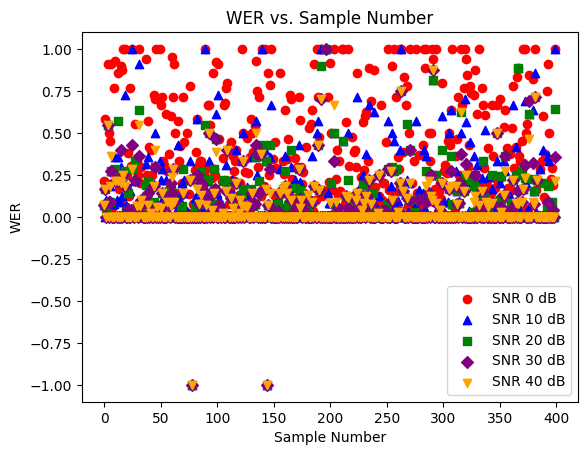

In [5]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["WER"]

# Define colors and symbols for each SNR value
snr_styles = {0: ('red', 'o'), 10: ('blue', '^'), 20: ('green', 's'), 30: ('purple', 'D'), 40: ('orange', 'v')}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

plt.figure()
for output_file_path in output_file_paths:
    snr, wer = plot_wer(output_file_path)
    unique_snr = np.unique(snr)
    for snr_value in unique_snr:
        color, marker = snr_styles[snr_value]
        mask = np.array(snr) == snr_value
        sample_numbers = np.arange(len(np.array(wer)[mask]))  # Create a range of sample numbers
        plt.scatter(sample_numbers, np.array(wer)[mask], c=color, marker=marker, label=f'SNR {snr_value} dB')

plt.xlabel("Sample Number")
plt.ylabel("WER")
plt.title("WER vs. Sample Number")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["PESQ"]

# Define colors and symbols for each SNR value
snr_styles = {0: ('red', 'o'), 10: ('blue', '^'), 20: ('green', 's'), 30: ('purple', 'D'), 40: ('orange', 'v')}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

plt.figure()
for output_file_path in output_file_paths:
    snr, pesq = plot_pesq(output_file_path)
    unique_snr = np.unique(snr)
    for snr_value in unique_snr:
        color, marker = snr_styles[snr_value]
        mask = np.array(snr) == snr_value
        sample_numbers = np.arange(len(np.array(pesq)[mask]))  # Create a range of sample numbers
        plt.scatter(sample_numbers, np.array(pesq)[mask], c=color, marker=marker, label=f'SNR {snr_value} dB')

plt.xlabel("Sample Number")
plt.ylabel("PESQ")
plt.title("PESQ vs. Sample Number")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)

    return data["SNR"], data["WER"]

# Define colors for each SNR value
snr_colors = {0: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

wer_data = {}
for output_file_path in output_file_paths:
    snr, wer = plot_wer(output_file_path)
    for snr_value, wer_value in zip(snr, wer):
        if snr_value not in wer_data:
            wer_data[snr_value] = []
        wer_data[snr_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for snr_value, wer_values in wer_data.items():
    color = snr_colors[snr_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'SNR {snr_value} dB')

plt.ylim(0, 50)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["PESQ"]

# Define colors for each SNR value
snr_colors = {0: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

pesq_data = {}
for output_file_path in output_file_paths:
    snr, pesq = plot_pesq(output_file_path)
    for snr_value, pesq_value in zip(snr, pesq):
        if snr_value not in pesq_data:
            pesq_data[snr_value] = []
        pesq_data[snr_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for snr_value, pesq_values in pesq_data.items():
    color = snr_colors[snr_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'SNR {snr_value} dB')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()
